In [8]:
import pandas as pd, json, re, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
import pandas as pd

files = {
    "bankier": "wyniki LLM/bankier_llm_extracted.csv",
    "businessinsider": "wyniki LLM/businessinsider_llm_extracted.csv",
    "money": "wyniki LLM/money_llm_extracted.csv",
    "obserwatorfinansowy": "wyniki LLM/obserwatorfinansowy_llm_extracted_clean.csv",
    "pap": "wyniki LLM/pap_llm_extracted.csv",
    "tvn24": "wyniki LLM/tvn24_llm_extracted.csv"
}

rows = []
for name, path in files.items():
    try:
        df = pd.read_csv(path)
        rows.append({"source": name, "articles": len(df)})
    except Exception as e:
        rows.append({"source": name, "articles": f"ERROR: {e}"})

pd.DataFrame(rows)




,source,articles
0,bankier,472
1,businessinsider,719
2,money,468
3,obserwatorfinansowy,514
4,pap,363
5,tvn24,683


In [9]:
# Parse forecasts_json -> normalized long df (one row per variable/year)
def _parse_row(raw: str):
    try:
        items = json.loads(raw)
    except Exception:
        return []
    out = []
    for f in items:
        if not isinstance(f, dict) or "variable" not in f or "value" not in f:
            continue
        var = str(f.get("variable", "")).strip().lower()
        # keep only known macro variables
        if var not in {"gdp","inflation","unemployment","deficit","public_debt","interest_rate","fx","wages","other"}:
            continue
        horizon = str(f.get("horizon", "")).strip()
        m = re.search(r"\b(\d{4})\b", horizon)
        if not m:
            # skip non-annual or unknown horizons
            continue
        year = int(m.group(1))
        # coerce numeric value
        try:
            val = pd.to_numeric(str(f["value"]).replace(",", "."), errors="coerce")
        except Exception:
            val = np.nan
        if pd.isna(val):
            continue
        out.append({
            "variable": var,
            "year": year,
            "value": float(val)
        })
    return out

rows = []
for i, r in df.iterrows():
    recs = _parse_row(r.get("forecasts_json", "[]"))
    for rr in recs:
        rr.update({
            "url": r.get("url"),
            "who": r.get("main_topic") or r.get("title_search") or ""
        })
        rows.append(rr)

forecasts_long = pd.DataFrame(rows)
# keep only key variables to avoid mixing in pivot
key_vars = ["gdp","public_debt","deficit","inflation","unemployment","interest_rate"]
forecasts_long = forecasts_long[forecasts_long["variable"].isin(key_vars)]

# Wide form: separate columns per variable (prevents mixing GDP/Public debt)
forecasts_wide = (forecasts_long
                  .pivot_table(index=["year","who"], columns="variable", values="value", aggfunc="first")
                  .reset_index())

# Example sanity check (no NaN due to mixing):
print(forecasts_wide.loc[forecasts_wide["year"].isin([2022,2023]), ["year","who","gdp","unemployment"]].head(10)) #"public debt"


variable  year                                                who  gdp  \
225       2022  Analiza zagrożeń ekonomicznych związanych z pr...  5.1   
226       2022  Global economic growth slowdown and inflation ...  3.6   
227       2022  Globalna gospodarka i prognozy makroekonomiczn... -1.5   
228       2022                                           Inflacja  NaN   
229       2022  Inflacja CPI w USA i inflacja cen sztywnych; p...  NaN   
230       2022  Inflacja cen domów i mieszkań oraz czynszów w USA  NaN   
231       2022  Inflacja i jej przyszłość w kontekście makroek...  NaN   
232       2022  Inflacja i perspektywy makroekonomiczne w stre...  NaN   
233       2022  Inflacja i rynek pracy w USA po pandemii COVID-19  NaN   
234       2022  Inflacja w Niemczech oraz wyzwania makroekonom...  NaN   

variable  unemployment  
225                NaN  
226                NaN  
227                3.6  
228                NaN  
229                NaN  
230                NaN  
231       

In [17]:
# Load actual values from dane_makroekonomiczne.json (prefer eurostat_gus, else oryginalne)
with open("dane_makroekonomiczne.json", "r", encoding="utf-8") as f:
    actual_raw = json.load(f)

name_map = {
    "gdp": "Realny wzrost PKB (% r/r)",
    "inflation": "Inflacja CPI (średnioroczna, %)",
    "interest_rate": "Stopa referencyjna NBP (średnioroczna, %)",
    "unemployment": "Stopa bezrobocia (BAEL / Eurostat, %)",
    "deficit": "Deficyt sektora GG (% PKB)",
    "public_debt": "Dług publiczny (GG, % PKB)"
}

ind_by_name = {ind["name"]: ind for ind in actual_raw.get("indicators", [])}

actual_rows = []
for var, ind_name in name_map.items():
    ind = ind_by_name.get(ind_name)
    if not ind:
        continue
    for y, vals in ind.get("values", {}).items():
        try:
            year = int(y)
        except Exception:
            continue
        val = vals.get("eurostat_gus")
        if val is None:
            val = vals.get("oryginalne")
        if val is None:
            continue
        actual_rows.append({"variable": var, "year": year, "actual": float(val)})

actual_df = pd.DataFrame(actual_rows)

# Join example to validate alignment for GDP and Public Debt
check = (forecasts_long[forecasts_long["variable"].isin(["gdp","public_debt"])]
         .merge(actual_df[actual_df["variable"].isin(["gdp","public_debt"])], on=["variable","year"], how="left"))

print(check.sort_values(["variable","year"]).head(12))


    variable  year  value                                                url  \
283      gdp  1980    3.5  https://www.obserwatorfinansowy.pl/tematyka/ry...   
916      gdp  1999    3.4  https://www.obserwatorfinansowy.pl/tematyka/ma...   
745      gdp  2000    0.7  https://www.obserwatorfinansowy.pl/tematyka/ma...   
917      gdp  2006    3.4  https://www.obserwatorfinansowy.pl/tematyka/ma...   
401      gdp  2007    1.7  https://www.obserwatorfinansowy.pl/bez-kategor...   
805      gdp  2007    3.2  https://www.obserwatorfinansowy.pl/tematyka/ry...   
118      gdp  2008   -0.3  https://www.obserwatorfinansowy.pl/bez-kategor...   
119      gdp  2009   -4.1  https://www.obserwatorfinansowy.pl/bez-kategor...   
424      gdp  2009    2.8  https://www.obserwatorfinansowy.pl/tematyka/ma...   
522      gdp  2009    4.0  https://www.obserwatorfinansowy.pl/tematyka/ry...   
523      gdp  2009    3.8  https://www.obserwatorfinansowy.pl/tematyka/ry...   
524      gdp  2009    0.4  https://www.o

## Porównanie prognoz z rzeczywistymi danymi


In [11]:
# Merge forecasts with actuals
comparison = forecasts_long.merge(
    actual_df, 
    on=['variable', 'year'], 
    how='left'
)

# Calculate forecast errors
comparison['error'] = comparison['value'] - comparison['actual']
comparison['abs_error'] = comparison['error'].abs()
comparison['pct_error'] = (comparison['error'] / comparison['actual'] * 100).replace([np.inf, -np.inf], np.nan)
comparison['abs_pct_error'] = comparison['pct_error'].abs()

# Filter only forecasts where we have actual data
comparison_valid = comparison[comparison['actual'].notna()].copy()

print(f"Total forecasts: {len(forecasts_long)}")
print(f"Forecasts with actual data: {len(comparison_valid)}")
print(f"\nYears with actual data: {sorted(comparison_valid['year'].unique())}")
print(f"Variables analyzed: {sorted(comparison_valid['variable'].unique())}")

Total forecasts: 1635
Forecasts with actual data: 588

Years with actual data: [2021, 2022, 2023]
Variables analyzed: ['deficit', 'gdp', 'inflation', 'interest_rate', 'public_debt', 'unemployment']


In [12]:
# Summary statistics by variable
summary_by_var = comparison_valid.groupby('variable').agg({
    'error': ['mean', 'std'],
    'abs_error': ['mean', 'median'],
    'abs_pct_error': ['mean', 'median'],
    'value': 'count'
}).round(2)

summary_by_var.columns = ['Mean Error', 'Std Error', 'MAE', 'Median AE', 'MAPE (%)', 'Median APE (%)', 'N']
print("\n=== Błędy prognoz według zmiennych ===")
print(summary_by_var)


=== Błędy prognoz według zmiennych ===
               Mean Error  Std Error     MAE  Median AE  MAPE (%)  \
variable                                                            
deficit             32.69      61.37   32.69       9.15    691.47   
gdp                207.65    2278.21  214.13       2.30   4005.66   
inflation           -3.50       8.49    6.06       5.20     51.02   
interest_rate       -1.93       2.19    2.37       2.48     91.69   
public_debt         20.28      56.58   45.69      42.45     89.10   
unemployment         3.66       6.15    3.77       2.00    130.49   

               Median APE (%)    N  
variable                            
deficit                194.34   18  
gdp                    122.64  325  
inflation               47.21  162  
interest_rate           56.90   16  
public_debt             85.89   28  
unemployment            68.97   39  


In [13]:
# Summary by year
summary_by_year = comparison_valid.groupby('year').agg({
    'error': ['mean', 'std'],
    'abs_error': 'mean',
    'abs_pct_error': 'mean',
    'value': 'count'
}).round(2)

summary_by_year.columns = ['Mean Error', 'Std Error', 'MAE', 'MAPE (%)', 'N']
print("\n=== Błędy prognoz według roku ===")
print(summary_by_year)


=== Błędy prognoz według roku ===
      Mean Error  Std Error     MAE  MAPE (%)    N
year                                              
2021      552.01    3671.35  557.13   8023.89  124
2022       -2.97      17.50    8.92    121.43  219
2023        1.58      20.48    6.48   1265.50  245


In [14]:
# Detailed comparison for specific variables
key_vars = ['gdp', 'inflation', 'unemployment', 'deficit', 'public_debt']

for var in key_vars:
    var_data = comparison_valid[comparison_valid['variable'] == var].copy()
    if len(var_data) == 0:
        continue
    
    print(f"\n=== {var.upper()} ===")
    print(f"Liczba prognoz: {len(var_data)}")
    print(f"Średni błąd: {var_data['error'].mean():.2f}")
    print(f"Średni błąd bezwzględny (MAE): {var_data['abs_error'].mean():.2f}")
    print(f"Średni błąd procentowy (MAPE): {var_data['abs_pct_error'].mean():.2f}%")
    
    # Show forecasts vs actuals by year
    yearly = var_data.groupby('year').agg({
        'value': ['mean', 'std', 'count'],
        'actual': 'first',
        'error': 'mean'
    }).round(2)
    print("\nPrzy year:")
    print(yearly)


=== GDP ===
Liczba prognoz: 325
Średni błąd: 207.65
Średni błąd bezwzględny (MAE): 214.13
Średni błąd procentowy (MAPE): 4005.66%

Przy year:
       value                actual   error
        mean      std count  first    mean
year                                      
2021  923.73  4730.27    74    6.9  916.83
2022    0.94    14.83   134    5.3   -4.36
2023    2.01     5.96   117    0.1    1.91

=== INFLATION ===
Liczba prognoz: 162
Średni błąd: -3.50
Średni błąd bezwzględny (MAE): 6.06
Średni błąd procentowy (MAPE): 51.02%

Przy year:
     value              actual error
      mean    std count  first  mean
year                                
2021  4.32   2.94    24    5.1 -0.77
2022  9.62  13.09    53   14.4 -4.78
2023  7.92   5.15    85   11.4 -3.48

=== UNEMPLOYMENT ===
Liczba prognoz: 39
Średni błąd: 3.66
Średni błąd bezwzględny (MAE): 3.77
Średni błąd procentowy (MAPE): 130.49%

Przy year:
     value             actual error
      mean   std count  first  mean
year           

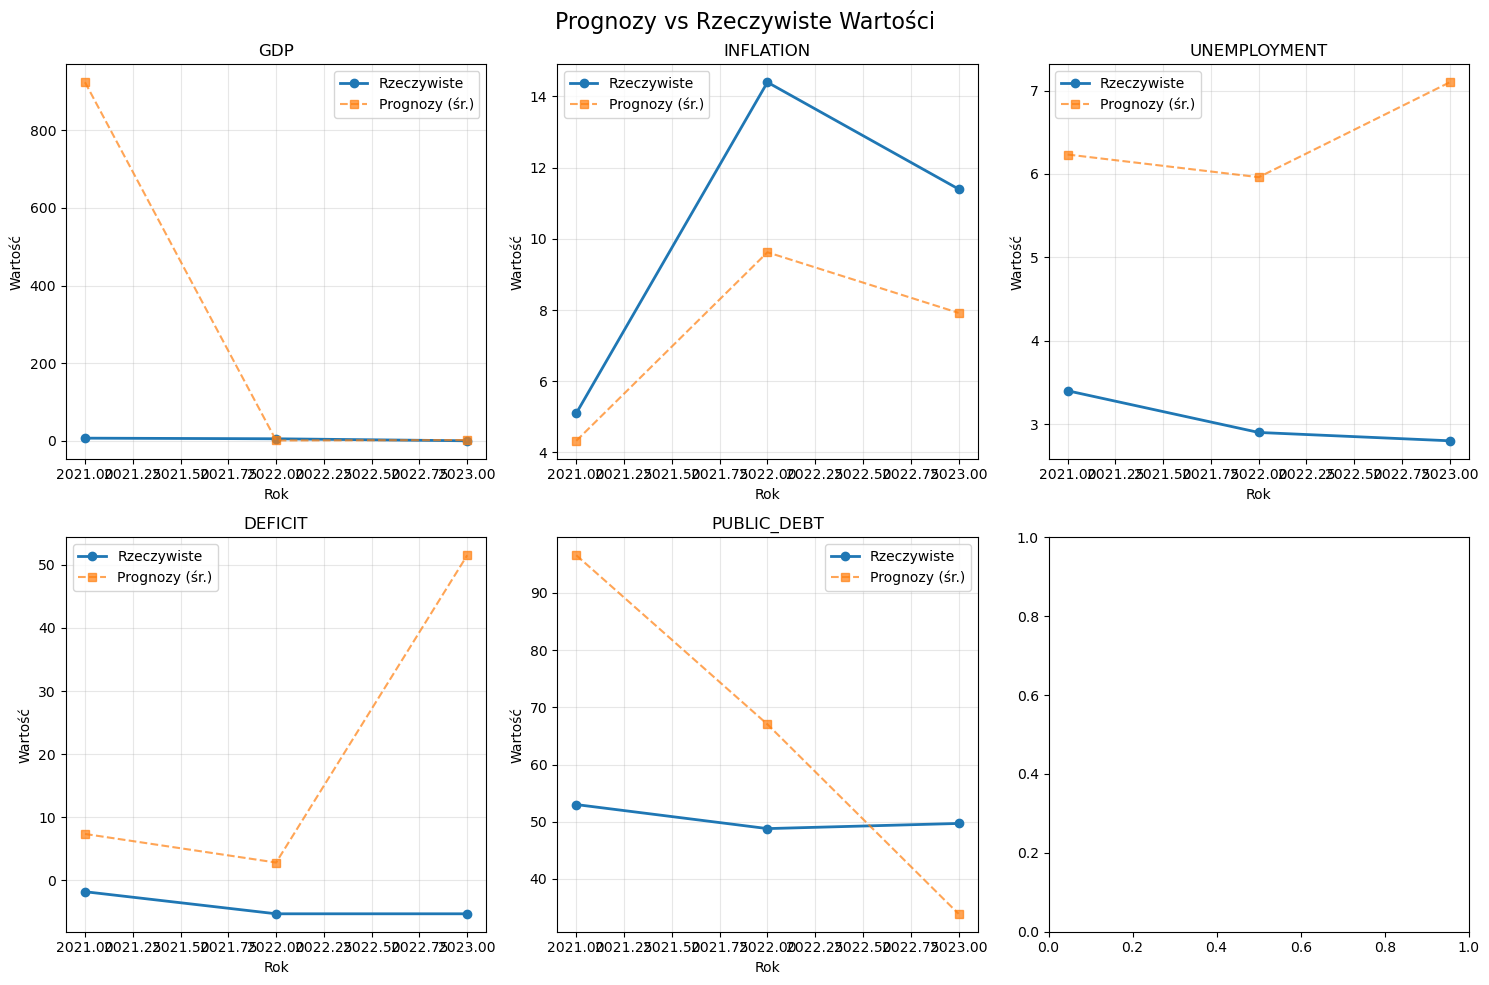

In [15]:
# Visualization: Forecast vs Actual for GDP
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Prognozy vs Rzeczywiste Wartości', fontsize=16)

for idx, var in enumerate(key_vars):
    if idx >= 6:
        break
    ax = axes[idx // 3, idx % 3]
    var_data = comparison_valid[comparison_valid['variable'] == var]
    
    if len(var_data) == 0:
        ax.set_visible(False)
        continue
    
    # Aggregate by year
    yearly_agg = var_data.groupby('year').agg({
        'value': 'mean',
        'actual': 'first'
    })
    
    ax.plot(yearly_agg.index, yearly_agg['actual'], 'o-', label='Rzeczywiste', linewidth=2)
    ax.plot(yearly_agg.index, yearly_agg['value'], 's--', label='Prognozy (śr.)', alpha=0.7)
    ax.set_xlabel('Rok')
    ax.set_ylabel('Wartość')
    ax.set_title(var.upper())
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

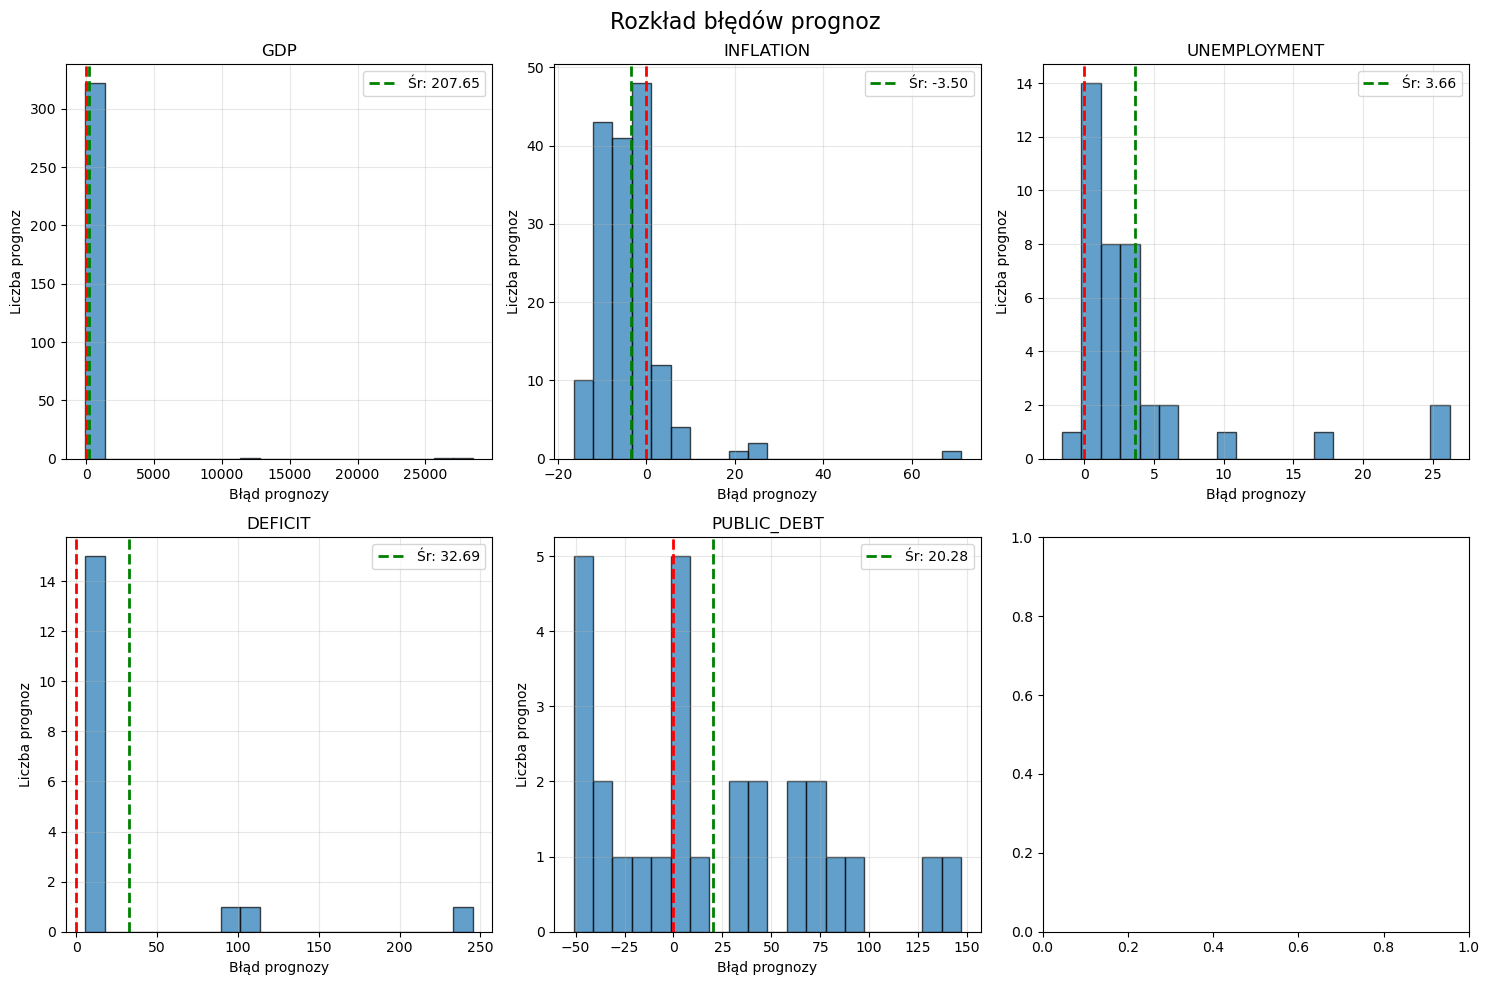

In [16]:
# Visualization: Error distribution
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Rozkład błędów prognoz', fontsize=16)

for idx, var in enumerate(key_vars):
    if idx >= 6:
        break
    ax = axes[idx // 3, idx % 3]
    var_data = comparison_valid[comparison_valid['variable'] == var]
    
    if len(var_data) == 0:
        ax.set_visible(False)
        continue
    
    ax.hist(var_data['error'], bins=20, edgecolor='black', alpha=0.7)
    ax.axvline(0, color='red', linestyle='--', linewidth=2)
    ax.axvline(var_data['error'].mean(), color='green', linestyle='--', linewidth=2, label=f"Śr: {var_data['error'].mean():.2f}")
    ax.set_xlabel('Błąd prognozy')
    ax.set_ylabel('Liczba prognoz')
    ax.set_title(var.upper())
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()